# Analiza Danych Multimedialnych
### **Projekt:** Rozpoznawanie gestów dłoni na podstawie American Sign Language

---

**Autorzy:**
- Norbert Lipowicz, 93977
- Najda Weronika, 97534

**Data wykonania projektu:**  19.01.2025

**Cel projektu**

Celem projektu jest stworzenie aplikacji do automatycznego rozpoznawania gestów dłoni na podstawie obrazów lub wideo, wykorzystując sieci neuronowe. System umożliwia identyfikację gestów w czasie rzeczywistym, co znajduje zastosowanie w interfejsach bezdotykowych, systemach wspomagających osoby z niepełnosprawnościami, edukacji oraz grach komputerowych.

**Opis projektu**

W ramach projektu zaimplementowano aplikację umożliwiającą rozpoznawanie gestów języka migowego w czasie rzeczywistym za pomocą kamery. System analizuje obraz dłoni przesyłany z kamery, rozpoznaje przedstawiony znak i natychmiast wyświetla wynik na ekranie. Aplikacja obsługuje wszystkie litery alfabetu amerykańskiego języka migowego (ASL) oraz dodatkowe gesty, takie jak spacja oraz usuń. W projekcie wykorzystano sekwencyjną sieć neuronową oraz model MediaPipe Hands, które analizują obraz, wyodrębniają kluczowe punkty dłoni i przypisują im odpowiednie znaki. Wyniki rozpoznawania są wyświetlane wraz z obrazem przechwyconej dłoni, co czyni aplikację intuicyjną i łatwą w obsłudze. Projekt zrealizowano przy użyciu technologii takich jak Python oraz biblioteki TensorFlow, MediaPipe, OpenCV i Tkinter.

---

**Opis zbioru**

Wybrany zbiór danych to *ASL Alphabet*, który zawiera obrazy przedstawiające litery alfabetu amerykańskiego języka migowego. Dane są poukładane w 29 folderach, z których każdy reprezentuje jedną klasę. 26 z nich odpowiada literom A-Z, a pozostałe 3 klasy to SPACE, DELETE i NOTHING, które są przydatne w aplikacjach czasu rzeczywistego. Całość podzielona jest w następujący sposób:

- Zbiór treningowy: 87 000 obrazów o rozdzielczości 200x200 pikseli.
- Zbiór testowy: 29 obrazów (po jednym na każdą klasę), co zachęca do stosowania testów na danych rzeczywistych.

Dane te służą do wspierania rozwój modeli do rozpoznawania języka migowego w aplikacjach takich jak tłumaczenie znaków na mowę w czasie rzeczywistym i wiele innych.

Źródło danych: [Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet).

**Przygotowanie danych**

1. Wyświetlenie liczby zdjęć dla każdej kategorii
    - W folderze z danymi wejściowymi sprawdzono liczbę obrazów w każdej kategorii, co potwierdziło równomierny rozkład danych.
    - Sprawdzono zawartość zbioru i upewniono się, że wszystkie obrazy mają taki sam rozmiar.

2. Przetwarzanie obrazów przy użyciu MediaPipe Hands
    - Wykorzystano model MediaPipe Hands do ekstrakcji współrzędnych kluczowych punktów dłoni z obrazów.
    - Podczas przetwarzania danych pominięto klasę NOTHING, ponieważ model MediaPipe odpowiada za wykrycie dłoni.
    - Proces przetwarzania obejmował iterację po obrazach w folderze z danymi, konwersję obrazów do formatu RGB, a następnie detekcję punktów dłoni.
    - Z każdego obrazu pozyskano 63 współrzędne (x, y, z), które opisują pozycje kluczowych punktów dłoni.
    - Zebrane dane zapisano w formacie CSV, gdzie każda próbka zawierała etykietę oraz wartości współrzędnych.
    - Ostatecznie wczytano przetworzone dane i wyświetlono liczbę danych dla każdej klasy. Można zauważyć, że część danych zostało odrzuconych przez model MediaPipe ze względu na brak wykrytej dłoni na obrazie.

3. Kodowanie etykiet
    - Etykiety klas zostały zakodowane na wartości numeryczne przy użyciu LabelEncoder.

4. Podział na zbiory treningowe, walidacyjne i testowe
    - Zbiór danych podzielono na część treningową (70%) oraz testowo-walidacyjną (30%).
    - Następnie dane testowo-walidacyjne podzielono na równe części (15% testowe i 15% walidacyjne).
    - Upewniono się, że rozkład klas w każdym zbiorze jest równomierny i zgodny ze strukturą całego zestawu danych.

In [3]:
import os
import cv2
import pathlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import mediapipe as mp
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

### Przetwarzanie danych

Wyświetlenie liczby zdjęć dla każdej kategorii

In [4]:
data_path = './asl_alphabet_train/asl_alphabet_train'
categories = os.listdir(data_path)

list_of_size = []
for category in categories:
    print(category, len(glob(os.path.join(data_path, category, '*.jpg'))))
    # sprawdzenie, czy wszystkie obrazy mają ten sam rozmiar
    # list_of_size += [cv2.imread(im).shape for im in glob(os.path.join(data_path, category, '*.jpg'))]
    # print(set(list_of_size))


A 3000
B 3000
C 3000
D 3000
del 3000
E 3000
F 3000
G 3000
H 3000
I 3000
J 3000
K 3000
L 3000
M 3000
N 3000
nothing 3000
O 3000
P 3000
Q 3000
R 3000
S 3000
space 3000
T 3000
U 3000
V 3000
W 3000
X 3000
Y 3000
Z 3000


Przetwarzanie zdjęć w punkty wykorzystując model mediapipe Hands (około 90 minut)

In [13]:
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Ścieżka do folderu z danymi
input_folder = "./asl_alphabet_train/asl_alphabet_train"
output_csv = "handpoints.csv"

data = []

# Iteracja po wszystkich obrazach w folderze
for label in os.listdir(input_folder):
    if label == 'nothing':
        continue
    label_path = os.path.join(input_folder, label)
    if os.path.isdir(label_path):
        for image_name in tqdm(os.listdir(label_path), desc=f"Etykieta {label}"):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue
            
            # MediaPipe wymaga obrazu RGB
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_image)
            
            if results.multi_hand_landmarks:
                # Pobierz współrzędne kluczowych punktów
                landmarks = results.multi_hand_landmarks[0]
                keypoints = []
                for lm in landmarks.landmark:
                    keypoints.extend([lm.x, lm.y, lm.z])  # Dodaj współrzędne x, y, z
                
                data.append([label] + keypoints)

# Zapisanie danych do pliku CSV
columns = ["label"] + [f"keypoint_{i}" for i in range(63)]
df = pd.DataFrame(data, columns=columns)
df.to_csv(output_csv, index=False)
print(f"Dane zapisane w {output_csv}")

Etykieta Z: 100%|██████████| 3000/3000 [03:42<00:00, 13.47it/s]


Dane zapisane w handpoints.csv


Sprawdzenie przetworzonych danych

In [20]:
df = pd.read_csv('handpoints.csv')

In [22]:
df.groupby("label").count()

,keypoint_0,keypoint_1,keypoint_2,keypoint_3,keypoint_4,keypoint_5,keypoint_6,keypoint_7,keypoint_8,keypoint_9,...,keypoint_53,keypoint_54,keypoint_55,keypoint_56,keypoint_57,keypoint_58,keypoint_59,keypoint_60,keypoint_61,keypoint_62
label,,,,,,,,,,,,,,,,,,,,,
A,2187,2187,2187,2187,2187,2187,2187,2187,2187,2187,...,2187,2187,2187,2187,2187,2187,2187,2187,2187,2187
B,2207,2207,2207,2207,2207,2207,2207,2207,2207,2207,...,2207,2207,2207,2207,2207,2207,2207,2207,2207,2207
C,1988,1988,1988,1988,1988,1988,1988,1988,1988,1988,...,1988,1988,1988,1988,1988,1988,1988,1988,1988,1988
D,2463,2463,2463,2463,2463,2463,2463,2463,2463,2463,...,2463,2463,2463,2463,2463,2463,2463,2463,2463,2463
E,2308,2308,2308,2308,2308,2308,2308,2308,2308,2308,...,2308,2308,2308,2308,2308,2308,2308,2308,2308,2308
F,2876,2876,2876,2876,2876,2876,2876,2876,2876,2876,...,2876,2876,2876,2876,2876,2876,2876,2876,2876,2876
G,2440,2440,2440,2440,2440,2440,2440,2440,2440,2440,...,2440,2440,2440,2440,2440,2440,2440,2440,2440,2440
H,2393,2393,2393,2393,2393,2393,2393,2393,2393,2393,...,2393,2393,2393,2393,2393,2393,2393,2393,2393,2393
I,2384,2384,2384,2384,2384,2384,2384,2384,2384,2384,...,2384,2384,2384,2384,2384,2384,2384,2384,2384,2384


Podział na dane treningowe, walidacyjne i testowe

In [23]:
X = df.drop("label", axis=1).values
y = df["label"].values
print(X.shape)
print(y.shape)

(63673, 63)
(63673,)


In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [30]:
# Krok 1: Podział na dane treningowe i testowo-walidacyjne (70% / 30%)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Krok 2: Podział danych testowo-walidacyjnych na testowe i walidacyjne (50% / 50%)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)

In [31]:
def print_class_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Rozkład klas w zbiorze {dataset_name}:")
    for label, count in zip(unique, counts):
        print(f"{label_encoder.inverse_transform([label])[0]}: {count}")
    print("\n")

print_class_distribution(y_train, "treningowym")
print_class_distribution(y_val, "walidacyjnym")
print_class_distribution(y_test, "testowym")

Rozkład klas w zbiorze treningowym:
A: 1531
B: 1545
C: 1392
D: 1724
E: 1616
F: 2013
G: 1708
H: 1675
I: 1669
J: 1805
K: 1890
L: 1769
M: 1095
N: 893
O: 1585
P: 1429
Q: 1465
R: 1779
S: 1786
T: 1644
U: 1761
V: 1784
W: 1719
X: 1511
Y: 1809
Z: 1646
del: 1191
space: 1137


Rozkład klas w zbiorze walidacyjnym:
A: 328
B: 331
C: 298
D: 369
E: 346
F: 431
G: 366
H: 359
I: 357
J: 387
K: 405
L: 379
M: 235
N: 192
O: 340
P: 306
Q: 314
R: 381
S: 383
T: 353
U: 378
V: 382
W: 368
X: 324
Y: 388
Z: 352
del: 255
space: 244


Rozkład klas w zbiorze testowym:
A: 328
B: 331
C: 298
D: 370
E: 346
F: 432
G: 366
H: 359
I: 358
J: 386
K: 405
L: 379
M: 235
N: 191
O: 340
P: 307
Q: 314
R: 381
S: 382
T: 352
U: 377
V: 382
W: 369
X: 323
Y: 388
Z: 353
del: 255
space: 244


---

### 2. Opis modelu

Ponieważ problem dotyczy klasyfikacji, jako model wybrano sekwencyjną sieć neuronową z framework'u TensorFlow/Keras.  
Model składa się z:
- **Warstwy wejściowej**  
    Warstwa wejściowa przyjmuje wektor jednowymiarowy o długości 63, co odpowiada liczbie cech opisującej każdą literę.
- **Pierwszej warstwy Dense**  
    Warstwa jest w pełni połączona z 128 neuronami. Funkcją aktywacji jest ReLu.
- **Dropout'u**
    Mechanizm regulacji, który wyłącza losowe neurony z aktywacji podczas treningu. Współczynnik 0.3 oznacza, że 30% neuronów zostanie losowo wyłączonych, aby zapobiec przeuczeniu.
- **Drugiej warstwy Dense**
    Warstwa jest w pełni połączona z 64 neuronami. Funkcją aktywacji jest ReLu.
- **Dropout'u**
    Ponowne zastosowanie z takim samym współczynnikiem w celu dalszej regularyzacji.
- **Warstwy wyjściowej Dense**
    Liczba neuronów w tej warstwie odpowiada liczbie klas (28). Funkcja aktywacji Softmax przekształca wyjścia w prawdopodobieństwa, gdzie najwyższe prawdopodobieństwo wskazuję klasę najbardziej prawdopodobną na podstawie zdjęcia.

---

### Stworzenie modelu Sequential

In [35]:
from tensorflow.keras import Sequential # type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation # type: ignore

model = Sequential([
    Input((X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

---

### 3. Trenowanie modelu 

Model został wytrenowany w ciągiu 20 epok, których trenowanie zajmowało po kilka sekund.

In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3137 - loss: 2.3575 - val_accuracy: 0.8870 - val_loss: 0.4898
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8100 - loss: 0.6128 - val_accuracy: 0.9414 - val_loss: 0.2820
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8806 - loss: 0.4027 - val_accuracy: 0.9441 - val_loss: 0.2214
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9062 - loss: 0.3165 - val_accuracy: 0.9467 - val_loss: 0.1827
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9201 - loss: 0.2684 - val_accuracy: 0.9439 - val_loss: 0.1714
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9277 - loss: 0.2404 - val_accuracy: 0.9674 - val_loss: 0.1402
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9336 - loss: 0.2216 - val_accuracy: 0.9681 - val_loss: 0.1303
Epoch 8/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9388 - loss: 0.

In [ ]:
model.save("asl_model_handpoints.keras")

---

### 4. Ewaluacja modelu

**Wyniki dokładności i strat**

Dokładność na danych testowych:
- Model osiągnął bardzo wysoką dokładność na zbiorze testowym: 97.61%. Oznacza to, że jest w stanie prawidłowo sklasyfikować większość znaków języka migowego.
- Średnie metryki precyzji, recall i F1-score również wskazują na skuteczność modelu.

Przebieg treningu na wykresach:
-  Dokładność w zbiorach treningowym i walidacyjnym szybko wzrasta na początku treningu i stabilizuje się blisko 98% w obu zbiorach. Wykres pokazuje, że model nie jest nadmiernie dopasowany ze względu na brak dużej różnicy między zbiorami treningowym a walidacyjnym.
- Strata w obu zbiorach systematycznie maleje, osiągając niskie wartości, co świadczy o efektywnym uczeniu modelu.

**Wyniki klasyfikacji**

 Macierz F1-score i recall:
- Większość klas osiągnęła wyniki zbliżone do 1.00 w metrykach precyzji, recall i F1-score.
- Wyjątki:
    - Klasa 13 (etykieta n): Najniższy wynik F1-score (0.78) i recall (0.65). Może to być spowodowane mniejszą różnorodnością próbek w tej klasie lub ich większą trudnością.

Ogólny rozkład wyników:
- Dokładność ogólna: 98%.
- Precyzja, recall i F1-score wynoszą 0.98, co potwierdza skuteczność modelu w większości klas.

In [38]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Dokładność na danych testowych: {test_accuracy * 100:.2f}%")

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - loss: 0.0822
Dokładność na danych testowych: 97.61%


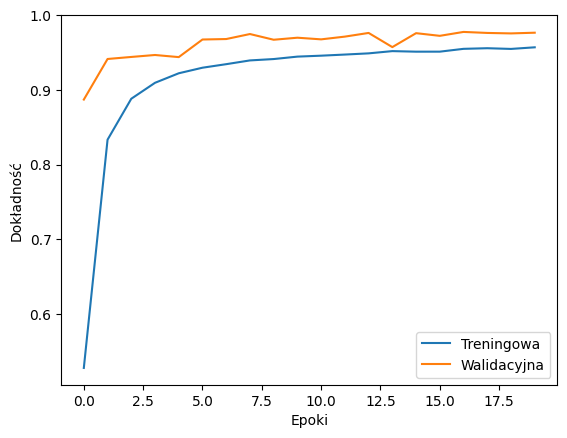

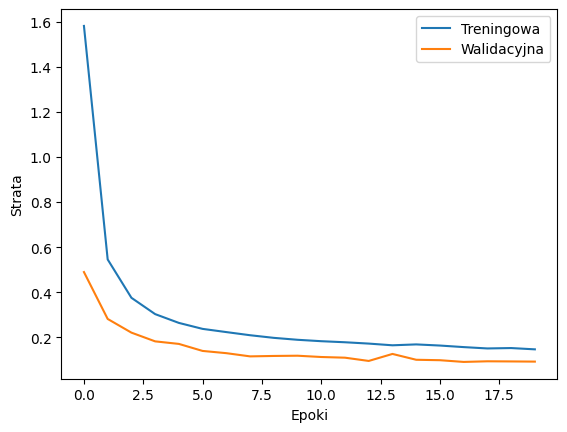

In [50]:
# Wykres dokładności
plt.plot(history.history['accuracy'], label='Treningowa')
plt.plot(history.history['val_accuracy'], label='Walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# Wykres strat
plt.plot(history.history['loss'], label='Treningowa')
plt.plot(history.history['val_loss'], label='Walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [55]:
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)
print(y_test)

[10 18  5 ... 24 17 26]
[10 12  5 ... 24 17 26]


In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       328
           1       0.99      1.00      0.99       331
           2       0.97      1.00      0.99       298
           3       1.00      0.98      0.99       370
           4       0.99      0.99      0.99       346
           5       0.99      0.99      0.99       432
           6       0.99      0.99      0.99       366
           7       0.99      1.00      0.99       359
           8       0.99      0.97      0.98       358
           9       1.00      0.98      0.99       386
          10       0.99      0.98      0.99       405
          11       1.00      1.00      1.00       379
          12       0.76      0.96      0.85       235
          13       0.98      0.65      0.78       191
          14       0.99      0.99      0.99       340
          15       0.99      0.97      0.98       307
          16       0.98      0.99      0.98       314
          17       0.99    

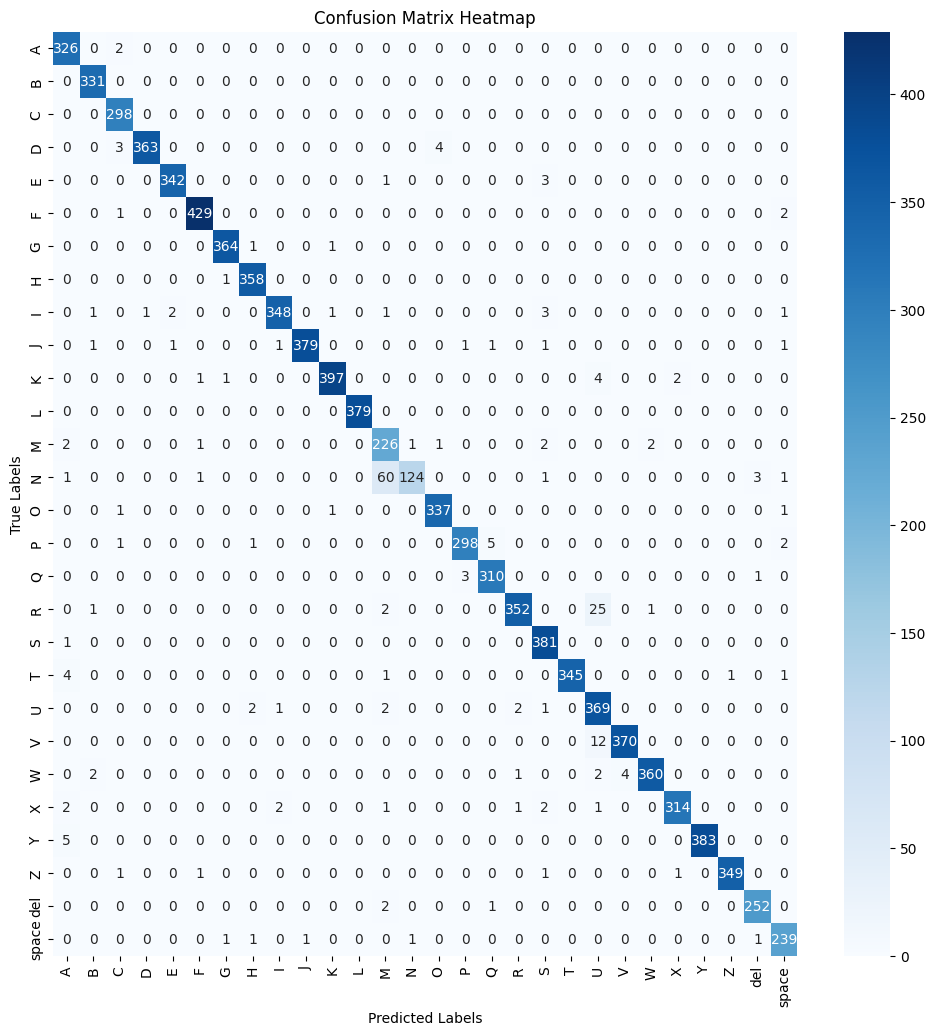

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Create the heatmap plot
plt.figure(figsize=(12, 12))  # Set figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(list(set(y))), yticklabels=sorted(list(set(y))))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Display the plot
plt.show()

### Testowanie modelu

In [ ]:
def preprocess_new_image(image_path):
    """
    Przetwarza nowe zdjęcie (z pliku) do formatu akceptowanego przez model.
    - image_path: ścieżka do zdjęcia.
    """
    # Wczytaj obraz
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Nie można wczytać obrazu: {image_path}")
    
    # Użyj MediaPipe do wyciągnięcia kluczowych punktów dłoni
    import mediapipe as mp
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Konwersja na RGB (MediaPipe wymaga RGB)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_image)

    if results.multi_hand_landmarks:
        # Pobierz współrzędne kluczowych punktów
        landmarks = results.multi_hand_landmarks[0]
        keypoints = []
        for lm in landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])  # Dodaj współrzędne x, y, z

        # Konwersja do formatu NumPy
        keypoints = np.array(keypoints).reshape(1, -1)  # 1 próbka, wiele cech
        return keypoints
    else:
        raise ValueError("Nie wykryto dłoni na obrazie.")

def predict_label(image_path):
    """
    Przewiduje etykietę dla nowego zdjęcia za pomocą wytrenowanego modelu.
    - image_path: ścieżka do zdjęcia.
    """
    try:
        # Przetwarzanie obrazu
        keypoints = preprocess_new_image(image_path)

        # Przewidywanie etykiety
        predictions = model.predict(keypoints)
        predicted_label_index = np.argmax(predictions)
        predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

        return predicted_label, predictions[0]
    except Exception as e:
        print(f"Błąd: {e}")
        return None, None


# Wczytaj klasy
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
           'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']
# classes = pd.read_csv("handpoints.csv")["label"].unique()
label_encoder = LabelEncoder()
label_encoder.fit(classes)

# Podaj ścieżkę do zdjęcia
test_img_path = r".\asl_alphabet_test\asl_alphabet_test\space_test.jpg"
result, _ = predict_label(test_img_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
space


---

### 5. Aplikacja

Wykorzystując prosty interfejs użytkownika oferowany przez bibliotekę Tkinter stworzono aplikację, która wykorzystuje wytrenowany model w celu detekcji liter alfabetu w czasie rzeczywistym. Przykład działania aplikacji:  

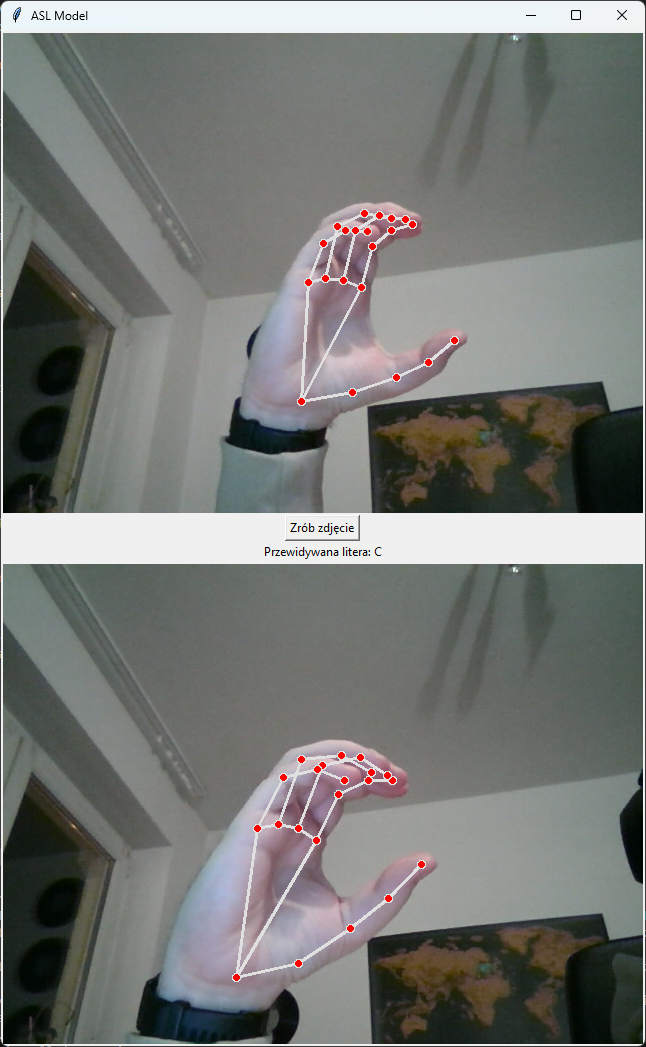  


Kod aplikacji:

In [ ]:
import cv2
from tkinter import *
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model # type: ignore
import mediapipe as mp

# Załaduj model
model = load_model(r"asl_model_handpoints.keras")

# Załaduj klasy
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
           'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']

# Konfiguracja MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Funkcja do przetwarzania klatek
def process_frame(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
            )
    return frame, results

# Funkcja do ekstrakcji kluczowych punktów
def extract_keypoints(results):
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        keypoints = []
        for lm in landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])  # Dodaj współrzędne x, y, z
        return np.array(keypoints).reshape(1, -1)
    return None

# Funkcja do przewidywania klasy
def predict_class(keypoints):
    predictions = model.predict(keypoints, verbose=0)
    predicted_label = classes[np.argmax(predictions)]
    if np.max(predictions) < 0.9:
        predicted_label = "Nie wykryto litery."
    return predicted_label

# Funkcja do aktualizacji obrazu w czasie rzeczywistym
def update_frame():
    global current_frame
    ret, frame = cap.read()
    if ret:
        frame = cv2.flip(frame, 1)  # Odbicie lustrzane
        frame, results = process_frame(frame)  # Przetwarzanie klatki
        current_frame = (frame, results)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(Image.fromarray(frame_rgb))
        lbl_video.imgtk = img
        lbl_video.configure(image=img)
        lbl_video.after(10, update_frame)

# Funkcja do przechwytywania obrazu i przewidywania klasy
def capture_and_predict():
    global current_frame
    frame, results = current_frame
    keypoints = extract_keypoints(results)
    if keypoints is not None:
        # Przewidywanie klasy
        predicted_label = predict_class(keypoints)

        # Wyświetlenie wyciętej dłoni
        lbl_result.config(text=f"Przewidywana litera: {predicted_label}")

        # Wyświetlenie przechwyconej dłoni
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(Image.fromarray(frame_rgb))
        lbl_hand.imgtk = img
        lbl_hand.configure(image=img)
    else:
        lbl_result.config(text="Nie wykryto dłoni.")

# Konfiguracja GUI
root = Tk()
root.title("ASL Model")

# Obraz z kamerki
lbl_video = Label(root)
lbl_video.pack()

# Przycisk do przechwytywania obrazu
btn_capture = Button(root, text="Zrób zdjęcie", command=capture_and_predict)
btn_capture.pack()

# Etykieta wyników
lbl_result = Label(root, text="Przewidywana litera: ---")
lbl_result.pack()

# Obraz przechwyconej dłoni
lbl_hand = Label(root)
lbl_hand.pack()

# Konfiguracja kamery
cap = cv2.VideoCapture(0)
current_frame = None
update_frame()

# Uruchomienie aplikacji
root.mainloop()
cap.release()
cv2.destroyAllWindows()


---

### 6. Podsumowanie

**Wnioski**
- Wysoka dokładność modelu potwierdza skuteczność połączenia ekstrakcji punktów charakterystycznych i klasyfikacji przy użyciu sieci neuronowych.
- Testy praktyczne pokazały wysoką skuteczność rozpoznawania gestów w czasie rzeczywistym.
- Szybka analiza w czasie rzeczywistym umożliwia użycie w aplikacjach praktycznych, np. w systemach wspierających osoby z niepeunosprawnościami.

**Sugestie dalszego rozwoju**
- Rozszerzenie możliwości rozpoznawania o dynamiczne gesty.
- Rozbudowa obsługi o inne języki migowe, jak Polski Język Migowy.